In [1]:
# Read hessian matrix and atomic masses/coordinates from Gaussian09 output file
# compute vibrational frequencies

In [2]:
from qm_subs import *
from chem_subs import *
import re
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [3]:
def hess2freq(hess, mass3, invmass=False, unweight=True):
    # given a hessian (in atomic units) and a cartesian mass vector (in amu),
    #    return the harmonic vibrational frequencies (cm**-1) and mode vectors
    # 'invmass' means that instead of cartesian masses we have cartesian
    #    inverse-square-root masses (in units of amu**-0.5)
    # 'unweight' causes mass weights to be removed from eigenvectors, 
    #    which are then renormalized
    #
    # convert masses from amu to atomic units
    if not invmass:
        mass3 = mass3 * AMU_AU
        # inverse mass weights
        alpha3 = mass3 ** -0.5
    else:
        alpha3 = mass3 * (AMU_AU ** -0.5)
    amat = np.outer(alpha3, alpha3)
    # mass-weighted hessian
    mhess = np.multiply(hess, amat)
    vals, vecs = np.linalg.eigh(mhess)
    # return imaginary freqs as negative reals
    freqs = np.sqrt(np.abs(vals)) * np.sign(vals)
    # freqs start with units = atomic unit of inverse of time = hbar/Eh
    freqs = freqs * AU_JOULE / HBAR
    # now freqs should be in s-1
    # convert to cm-1 and from angular to periodic
    freqs = freqs / (CLIGHT * 100) / (2 * np.pi)
    if unweight:
        # remove inverse mass weights from eigenvectors
        mvecs = np.divide(vecs, amat)
        # normalize rows
        nrms = np.linalg.norm(mvecs, axis=1)
        mvecs = mvecs / nrms
        return freqs, mvecs
    else:
        return freqs, vecs

In [4]:
def termin_mass_scale(Geom, hess, minv3, A=0.040):
    # directional mass-weighting of terminal atoms
    # return vibrational frequencies (in cm**-1) and mode vectors
    #
    # find the terminal atoms and their normalized bond vectors
    terminal = []
    bvec = []
    blist = Geom.bonded_list()
    for i in range(len(blist)):
        if len(blist[i]) == 1:
            terminal.append(i)
            bvec.append(Geom.vec(i, blist[i][0], 1.0))
        else:
            bvec.append([])
    # scale each cartesian component according to its bond-vector component
    minv = minv3.reshape(-1,3).copy()
    for iatom in terminal:
        for j in [0, 1, 2]:
            mu = minv[iatom, j]
            minv[iatom, j] = mu - A * abs(bvec[iatom][j]) / (mu * mu)
    minv = minv.flatten()
    freqs, vecs = hess2freq(hess, minv, invmass=True)
    return freqs, vecs

In [5]:
fgau = 'h2o_freq.out'

In [6]:
# get the frequencies as computed by Gaussian
regx = re.compile('Frequ')
gaufreqs = []
with open(fgau) as f:
    for line in f:
        if regx.search(line):
            fields = line.split()
            gaufreqs.extend(fields[2:])
gaufreqs = np.array(gaufreqs, dtype=float)

In [7]:
# experimental fundamentals for water, from CCCBDB
expt = np.array([1595., 3657., 3756.])

In [8]:
# get the initial geometry
Geom = read_qm_Geometry('gaussian09', fgau)[0]
#Geom.printXYZ(comment='initial geometry for {:s}'.format(Geom.stoichiometry()))

In [9]:
masses = np.array(read_g09_atom_masses(fgau))
Geom.set_masses(masses)
mass3 = Geom.massVector(tripled=True)
#mass3 = np.array([masses] * 3).T.flatten()  # isotropic masses

In [10]:
arch = read_g09_archive_block(fgau)
arch = parse_g09_archive_block(arch)

In [11]:
minv3 = mass3 ** -0.5
freqs, mvecs = hess2freq(arch['hessian'], minv3, invmass=True)

In [12]:
nfreq = len(mass3) - 6

In [13]:
results = pd.DataFrame(np.array([expt, freqs[-nfreq:], gaufreqs]).T, 
        columns = ['expt', 'this', 'G09'])
results

,expt,this,G09
0,1595.0,1645.527476,1645.5307
1,3657.0,3810.551832,3810.5608
2,3756.0,3919.730054,3919.7389


In [14]:
freqs, vecs = termin_mass_scale(Geom, arch['hessian'], minv3, A=0.040)
results = pd.DataFrame(np.array([expt, freqs[-nfreq:], gaufreqs]).T, 
        columns = ['expt', 'this', 'G09'])
results

,expt,this,G09
0,1595.0,1636.459365,1645.5307
1,3657.0,3669.790194,3810.5608
2,3756.0,3778.735952,3919.7389


In [23]:
# generate A-dependence for plotting
Avals = np.arange(0.03, 0.05, 0.001)
freqs = []
for A in Avals:
    f, v = termin_mass_scale(Geom, arch['hessian'], minv3, A=A)
    freqs.append(f[-nfreq:])
freqs = np.array(freqs)

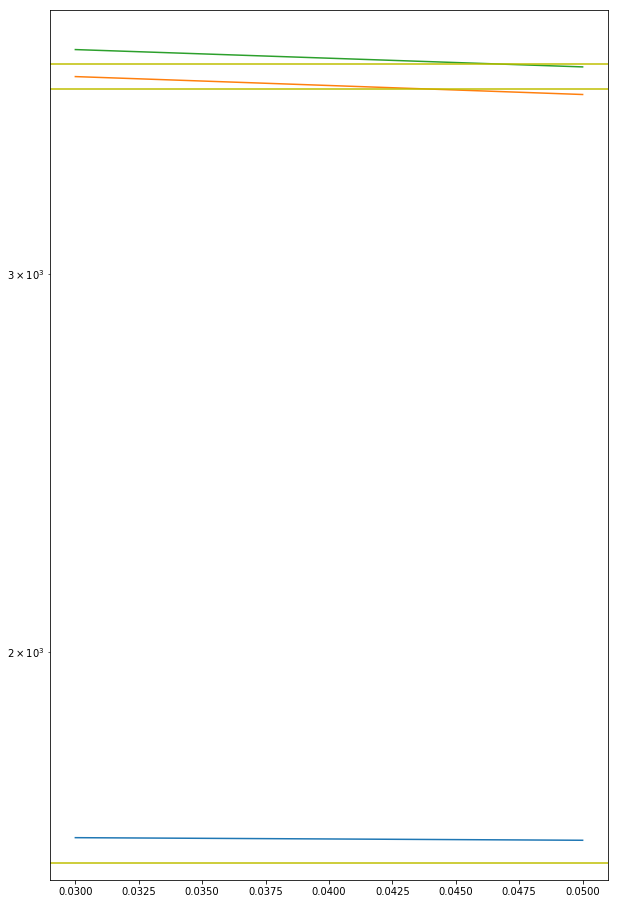

In [35]:
plt.semilogy(Avals, freqs)
for xfreq in expt:
    plt.axhline(y=xfreq, color='y', linestyle='-')
plt.rcParams["figure.figsize"] = [10, 16]
plt.show()